# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>
---

**Lab 04**: Data Unions & Joins Pipeline

**Date**: September 23rd 2025

**Student Name**: Ana Carolina Arellano Valdez

**Professor**: Pablo Camarillo Ramirez

## Initializing Spark Session

In [ ]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on SparkSQL") \
    .master("spark://9e979d8772f7:7077") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

## Build schema for each DataFrame

In [10]:
# Build schema
# Import your module
from carolinarellano.spark_utils import SparkUtils

schema_agencies = SparkUtils.generate_schema([("agency_id", "int"), ("agency_info", "string")])
schema_brands = SparkUtils.generate_schema([("brand_id", "int"), ("brand_info", "string")])
schema_cars = SparkUtils.generate_schema([("car_id", "int"), ("car_info", "string")])
schema_customers = SparkUtils.generate_schema([("customer_id", "int"), ("customer_info", "string")])
schema_rentals = SparkUtils.generate_schema([("rental_id", "int"), ("rental_info", "string")])

df_agencies = spark.read.schema(schema_agencies).option("header", True).csv("/opt/spark/work-dir/data/car_service/agencies")
df_brands = spark.read.schema(schema_brands).option("header", True).csv("/opt/spark/work-dir/data/car_service/brands")
df_cars = spark.read.schema(schema_cars).option("header", True).csv("/opt/spark/work-dir/data/car_service/cars")
df_customers = spark.read.schema(schema_customers).option("header", True).csv("/opt/spark/work-dir/data/car_service/customers")
df_rentals = spark.read.schema(schema_rentals).option("header", True).csv("/opt/spark/work-dir/data/car_service/rentals")

## Get JSON info

In [11]:
from pyspark.sql.functions import get_json_object, col

df_agencies = df_agencies.withColumn("agency_name", get_json_object(col("agency_info"), "$.agency_name")).drop("agency_info")
df_cars = df_cars.withColumn("car_name", get_json_object(col("car_info"), "$.car_name")).drop("car_info")
df_customers = df_customers.withColumn("customer_name", get_json_object(col("customer_info"), "$.customer_name")).drop("customer_info")

df_rentals = df_rentals \
    .withColumn("car_id", get_json_object(col("rental_info"), "$.car_id").cast("int")) \
    .withColumn("customer_id", get_json_object(col("rental_info"), "$.customer_id").cast("int")) \
    .withColumn("agency_id", get_json_object(col("rental_info"), "$.agency_id").cast("int")) 


## Join DataFrames

In [12]:
df_rentals = df_rentals \
    .join(df_cars, "car_id", "inner") \
    .join(df_customers, "customer_id", "inner") \
    .join(df_agencies, "agency_id", "inner") \
    .select("rental_id", "car_name", "customer_name", "agency_name") \
    .orderBy("rental_id", ascending=False)

## Results

In [13]:
df_rentals.show(5)

+---------+--------------------+-------------+-------------+
|rental_id|            car_name|customer_name|  agency_name|
+---------+--------------------+-------------+-------------+
|    17833|Grimes-Green Model 8| Jill Sherman|LA Car Rental|
|    17832|Walker, Pratt and...|    Troy Bell| Zapopan Auto|
|    17831|  Levy Group Model 9| Lisa Baldwin| Zapopan Auto|
|    17830|Alvarez-Davis Mod...| David Walker|LA Car Rental|
|    17829|Patrick, Barrera ...|  Blake Jones|LA Car Rental|
+---------+--------------------+-------------+-------------+
only showing top 5 rows


## Partitioning

In [14]:
base_path = "/opt/spark/work-dir/data/"

df_rentals.write \
            .partitionBy("agency_name") \
            .mode("overwrite") \
            .option("header", True) \
            .csv(base_path + "car_service/output/csv")

!ls data/car_service/output/csv
!du -sh data/car_service/output/csv/

'agency_name=LA Car Rental'  'agency_name=SF Cars'	  _SUCCESS
'agency_name=NYC Rentals'    'agency_name=Zapopan Auto'
832K	data/car_service/output/csv/


## Power BI Dashboard
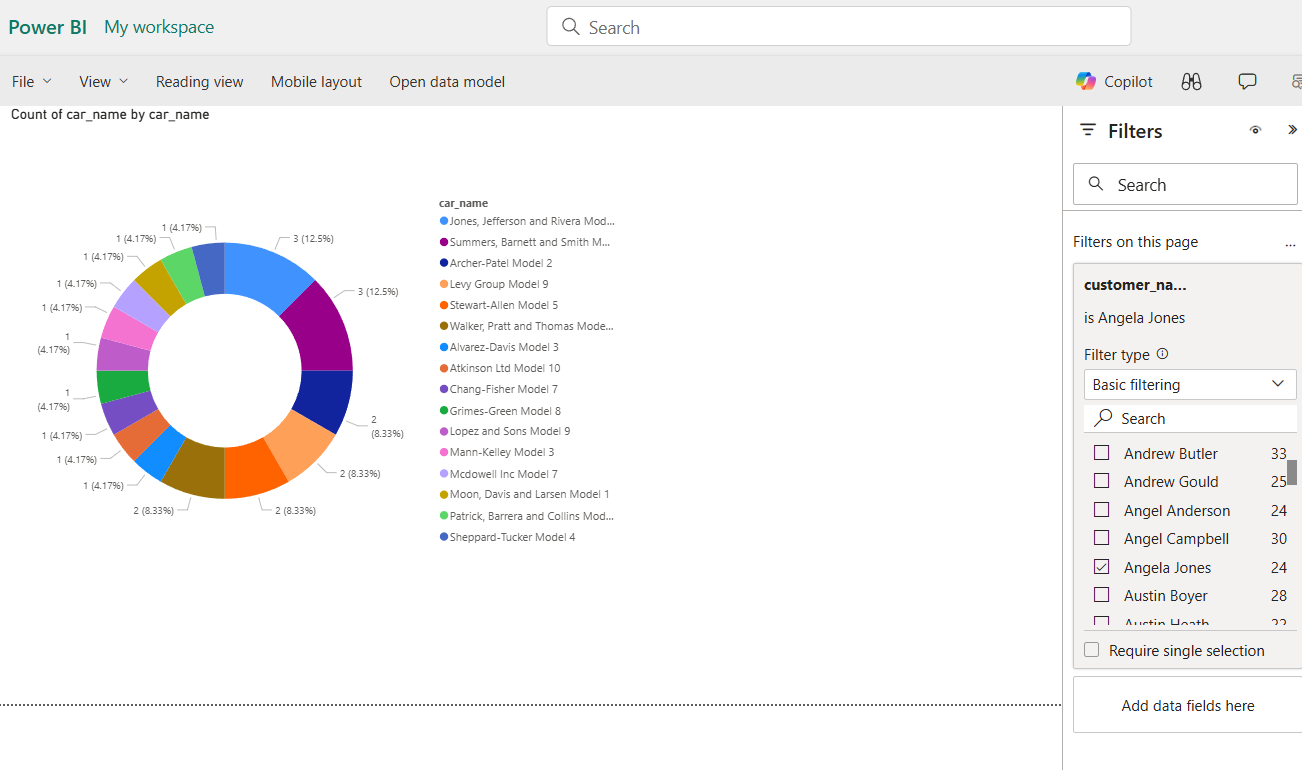

In [15]:
# sc.stop()